# Exercises for Introduction to Quantum Computing

Name: Pugazharasu Anancia Devaneyan (s6puanan) <br />
Matriculation number: 3300280

In [1]:
import numpy as np
import qiskit as qi
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile

from qiskit.visualization import plot_histogram

## 1. Quantum Fourier Transform

The quantum Fourier transform operation acting on a state is a unitary operation, thus for
$$\mathrm{qFT}^{\dagger}|\phi\rangle=|100\rangle$$
we simply act with a qFT on both sides of the equation to get,
$$|\phi\rangle =\mathrm{qFT}|100\rangle$$
Thus, to obtain the state, we simply need to evaluate the RHS. This can be done as the qFT in the computational basis is expressed as,
$$\mathrm{qFT}|j\rangle=\frac{1}{\sqrt{8}} \sum_{k=0}^7 e^{2 \pi i \frac{j k}{8}}|k\rangle$$

Therefore, we have
$$|\phi\rangle = \frac{1}{\sqrt(8)}\left(|000\rangle-|001\rangle+|010\rangle-|011\rangle+|100\rangle-|101\rangle+|110\rangle-|111\rangle \right)$$
The probability of measuring the output 100 from the state $|\phi\rangle$ is given by computing the inner product of $|\phi\rangle$ with $|100\rangle$,
$$ \langle 100 |\phi\rangle = {\left(\frac{1}{\sqrt{8}}\right)}^{2} = \frac{1}{8}$$

The inverse qFT circuit can be implemented by simply reversing the order of unitaries and inverting the angles of the phase gates applied i.e. $R_{h} \rightarrow R^{-1}_{h}$, thus for the 3-qubit case (excluding swaps) we have:

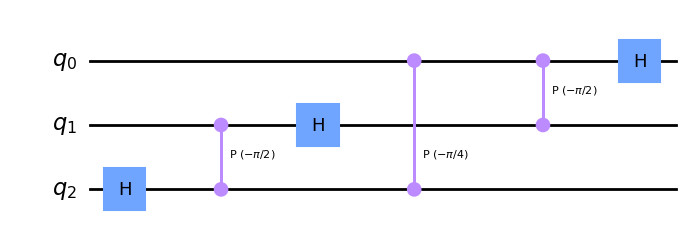

In [42]:
inv_qFT = QuantumCircuit(3)
inv_qFT.h(2)
inv_qFT.cp(-np.pi/2, 2, 1)
inv_qFT.h(1)
inv_qFT.cp(-np.pi/4, 2, 0)
inv_qFT.cp(-np.pi/2, 1, 0)
inv_qFT.h(0)
inv_qFT.draw('mpl')

In [21]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

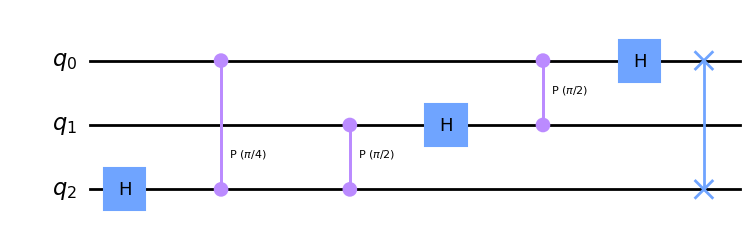

In [23]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(3)
qft(qc,3)
qc.draw('mpl')

In [26]:
state = qi.quantum_info.Statevector.from_label('001')
state.draw(output='latex')

<IPython.core.display.Latex object>

In [28]:
state = state.evolve(qc)
state.draw(output='latex')

<IPython.core.display.Latex object>

## 2. Deutsch–Jozsa algorithm

We wish to implement an Oracle $U_f$ with the action
$$U_{f} | q_{0} q_{1} q_{2} \rangle = |q_{0}q_{1}(q_{2} \oplus f(q_{0},q_{1})) \rangle$$
This is given to us via the quantum circuit,

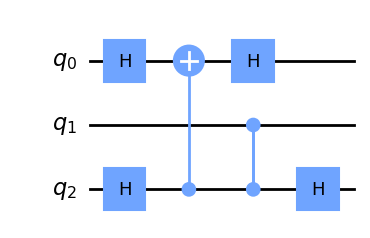

In [2]:
oracle = QuantumCircuit(3)
oracle.h(0)
oracle.h(2)
oracle.cx(2,0)
oracle.h(0)
oracle.cz(2,1)
oracle.h(2)
oracle.draw('mpl')

We can check if this does indeed implement the Oracle we desire by means of applying it to an arbitary state,

In [3]:
state = qi.quantum_info.Statevector.from_label('001')
state = state.evolve(oracle)
state.draw(output='latex')

<IPython.core.display.Latex object>

Now that we have shown that the quantum circuit implements an Oracle, we can check if the Oracle is balanced or constant by means of implementing a truth table for it,
<center>

| $ q_0 q_1 q_2 $ | $U_f$ |
| - | - |
| 000 | 000 |
| 001 | 100 |
| 010 | 011 |
| 011 | 010 |
| 100 | 101 |
| 101 | 100 |
| 110 | 110 |
| 111 | 111 |

</center>

We can see that the Oracle is balanced! We shall now construct the Deutsch Josza algorithm using Qiskit,

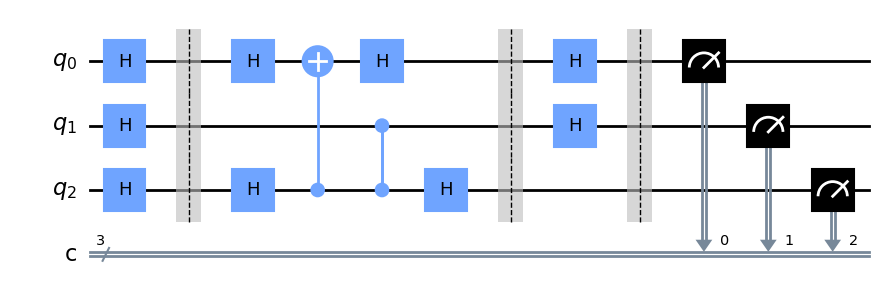

In [21]:
deutsch_algo = QuantumCircuit(3,3)
deutsch_algo.h(0)
deutsch_algo.h(1)
deutsch_algo.h(2)
deutsch_algo.barrier()
deutsch_algo = deutsch_algo.compose(oracle)
deutsch_algo.barrier()
deutsch_algo.h(0)
deutsch_algo.h(1)
deutsch_algo.barrier()
deutsch_algo.measure(0, 0)
deutsch_algo.measure(1, 1)
deutsch_algo.measure(2, 2) 
deutsch_algo.draw('mpl')

We can now check using the circuit if the function is balanced or not by means of running it on a QASM simulator,

In [22]:
backend = qi.Aer.get_backend('qasm_simulator')
job = qi.execute(deutsch_algo, backend, shots = 1024)
results = job.result()
counts = results.get_counts(deutsch_algo)
print(counts)

{'000': 495, '100': 529}


We can see that the function is balanced as shown above, thus the circuit implements the Deutsch Josza algorithm.